# Vulcain Nozzle Extension

This is an extension of the 'Vulcain Combustion Chamber.ipynb' notebook, but here we will attempt to model the dump-cooled nozzle extension here. <b> The key thing to note is that the nozzle extension using <u>spiralling</u> channels</b>.

Note:
The cooling channels taper at the coolant inlet, which must be accounted to consider the extra heat transfer in this section. I have not been able to find details on the taper except an undefined dimension in [2], which I assume to have been a square 'width x height' of 2.8x4 mm.


### References:

- [1] - Kirner et al 1993, Development Status of the Vulcain Thrust Chamber (http://ftp.demec.ufpr.br/CFD/bibliografia/propulsao/kirner_et_al_1993.pdf)
- [2] - Nydén et al 1991, Development of the HM60-Vulcain nozzle extension (https://arc.aiaa.org/doi/10.2514/6.1991-2566)
- [3] - LeBail et al 1993, Numerical analysis of high aspect ratio cooling passage flow and heat transfer (https://arc.aiaa.org/doi/pdf/10.2514/6.1993-1829)
- [4] - High Temp Metals, Inconel 600 Technical Data, (https://www.hightempmetals.com/techdata/hitempInconel600data.php)
- [5] - Ljungkrona et all 1998, Cooling Performance of the Nozzle Extension of the Ariane 5 Core Stage Engine Vulcain (https://arc.aiaa.org/doi/10.2514/6.1998-4012)

In [1]:
import bamboo as bam
import pypropep as ppp
from CoolProp.CoolProp import PropsSI
import cantera as ct
import matplotlib.pyplot as plt
import numpy as np
import json

### Collect Vulcain data

Using a an online graph image-to-data converter (http://www.graphreader.com/), we can obtain the raw data.

In [2]:
data = json.load(open("data/vulcain.json"))

# Cooling channel data
coolant_inlet_p0 = 137.9e5          # Coolant inlet pressure [3] (guess that p0 ~= p)
mdot_coolant = 1.75                 # Coolant mass flow rate [2] 
k_wall = 19.2                       # Wall thermal conductivity [4] for Inconel 600 [1]
wall_thickness = 0.4e-3             # Wall thickness between coolant and exhaust gas [2]
number_of_channels = 456            # Number of channels [2]
channel_height = 3.2e-3             # Height of cooling channels [2]
roughness = 5e-6                    # Representative value for machined metal [NEED REFERENCE]
    
# Fraction of cooling channel flow area that is blocked by fins/walls [2]
x_taper_start = data["Kirner"]["Extension Contour"]["x"][0]
x_taper_end = np.interp(0.15, 
                        [0, 4.15], 
                        [data["Kirner"]["Extension Contour"]["x"][0], data["Kirner"]["Extension Contour"]["x"][-1]])

def blockage_ratio(x):  
    if x < x_taper_end:
        return 0.2857     # (0.4 + 0.4) / 2.8
    else:    
        return 0.2        # (0.4 + 0.4) / 4                
    
# Cooling channel helix pitch [2] - number of tubes * width of each tube
def channel_width(x):
    if x < x_taper_end:
        return  2.8e-3       
    else:    
        return 4e-3              

# Chamber conditions data
thrust = 1007.7e3   # Vacuum thrust, N [1]
isp = 439*9.81      # Specific impulse, m/s [1]
pc = 100e5          # Chamber pressure, bar [1]
OF_ratio = 5.6      # O/F ratio (seems to be by mass) [1]

### Get chamber conditions

Use pypropep. The Vulcain uses a liquid oxygen and liquid hydrogen fed system.

In [3]:
# Use pypropep to get chamber temperature
ppp.init()
p_froz = ppp.FrozenPerformance()
lox = ppp.PROPELLANTS['OXYGEN (LIQUID)']
lh2 = ppp.PROPELLANTS['HYDROGEN (CRYOGENIC)']

# Add propellants by mass fractions
p_froz.add_propellants_by_mass([(lox, OF_ratio), (lh2, 1)])

# Adiabatic combustion using chamber pressure                      
p_froz.set_state(P = pc/1e5, Pe = 1)   

# Get results - use throat conditions for gamma and cp! Otherwise the perfect gas model deviates a lot from equilibrium calculations.
gamma = p_froz.properties[1].Isex   # pyrpopep uses 'Isex' for the ratio of specific heats. Index 1 means throat conditions
cp = 1000*p_froz.properties[1].Cp   # Cp is given in kJ/kg/K, we want J/kg/K
Tc = p_froz.properties[0].T         # Index 0 means chamber conditions

print(f"Chamber temperature = {Tc} K")

print("\nCombustion product composition:")
print(p_froz.composition["throat"])

Loaded 1921 thermo species
Loaded 1031 propellants
Chamber temperature = 3459.2606127242298 K

Combustion product composition:
[('H2O', 0.6493671319106238), ('H2', 0.2896925690851782), ('OH', 0.028980423622929952), ('H', 0.028801796474919292), ('O', 0.0016810512414820072), ('O2', 0.0014520541971763574), ('HO2', 1.7031381331243065e-05), ('H2O2', 7.94208687267654e-06), ('O3', 0.0)]


### Bamboo engine model

First set up the perfect gas model, the geometry, and combustion chamber conditions. Use this to get the mass flow rate of exhaust gas.

In [4]:
# Set up the chamber conditions and geometry
perfect_gas = bam.PerfectGas(gamma = gamma, cp = cp)   
chamber_conditions = bam.ChamberConditions(p0 = pc, T0 = Tc)
geometry = bam.Geometry(xs = data["Kirner"]["Engine Contour"]["x"], 
                        ys = data["Kirner"]["Engine Contour"]["y"])

# Set up an engine quickly just to get our perfect gas mass flow rate (used later)
engine = bam.Engine(perfect_gas = perfect_gas, 
                    chamber_conditions = chamber_conditions, 
                    geometry = geometry)

Now use Cantera to get the exhaust gas transport properties, and CoolProp to get the coolant transport properties.

In [5]:
# Setup the exhaust gas transport properties using Cantera
gas = ct.Solution('gri30.yaml')
gas.TPY = Tc, pc, f"H2:{1}, O2:{OF_ratio}"
gas.equilibrate("TP")

def mu_exhaust(T, p):
    gas.TP = T, p
    return gas.viscosity

def k_exhaust(T, p):
    gas.TP = T, p
    return gas.thermal_conductivity

def Pr_exhaust(T, p):
    gas.TP = T, p
    return gas.cp * gas.viscosity / gas.thermal_conductivity # Definition of Prandtl number

exhaust_transport = bam.TransportProperties(Pr = Pr_exhaust,
                                            mu = mu_exhaust,
                                            k = k_exhaust)

# Set up the coolant transport properties using CoolProp
# Round temperatures up to 12 K - CoolProp seems unhappy below this for LH2
def Pr_coolant(T, p):
    return PropsSI("PRANDTL", "T", T, "P", p, "HYDROGEN")

def mu_coolant(T, p):
    return PropsSI("VISCOSITY", "T", T, "P", p, "HYDROGEN")

def k_coolant(T, p):
    return PropsSI("CONDUCTIVITY", "T", T, "P", p, "HYDROGEN")

def cp_coolant(T, p):
    return PropsSI("CPMASS", "T", T, "P", p, "HYDROGEN")

def rho_coolant(T, p):
    return PropsSI("DMASS", "T", T, "P", p, "HYDROGEN") 

# Note that H2 doesn't seem to exactly 'boil-off' in the state it's in - it's supercritical
coolant_transport = bam.TransportProperties(Pr = Pr_coolant,
                                            mu = mu_coolant,
                                            k = k_coolant,
                                            cp = cp_coolant,
                                            rho = rho_coolant)

Put the final pieces together, set up the `Engine` object, and plot the geometry.

In [6]:
cooling_jacket = bam.CoolingJacket(T_coolant_in = data["Kirner"]["Extension Coolant Temperature (Sim)"]["y"][0],                           
                                   p0_coolant_in = coolant_inlet_p0, 
                                   coolant_transport = coolant_transport, 
                                   mdot_coolant = mdot_coolant, 
                                   configuration = "spiral", 
                                   channel_height = channel_height,
                                   number_of_fins = number_of_channels,
                                   blockage_ratio = blockage_ratio,
                                   roughness = roughness,
                                   channel_width = channel_width,
                                   xs = [data["Kirner"]["Extension Contour"]["x"][0], 
                                         data["Kirner"]["Extension Contour"]["x"][-1]])

wall = bam.Wall(material = bam.Material(k = k_wall), thickness = wall_thickness)

engine = bam.Engine(perfect_gas = perfect_gas, 
                    chamber_conditions = chamber_conditions, 
                    geometry = geometry,
                    cooling_jacket = cooling_jacket,
                    exhaust_transport = exhaust_transport,
                    walls = wall,
                    coolant_convection = "gnielinski",
                    exhaust_convection = "bartz-sigma",
                    h_exhaust_sf = 1,
                    h_coolant_sf = 1)

C:\Users\Daniel\OneDrive - University of Cambridge\Cambridge\CUSF\Github Repositories\Bamboo Repository\bamboo\circuit.py:263: ComplexWarning: Casting complex values to real discards the imaginary part
  self.T[i] = self.T[i-1] - self.Qdot*R[i-1]
<ipython-input-5-2b9beb79c421>:37: ComplexWarning: Casting complex values to real discards the imaginary part
  return PropsSI("DMASS", "T", T, "P", p, "HYDROGEN")
<ipython-input-5-2b9beb79c421>:25: ComplexWarning: Casting complex values to real discards the imaginary part
  return PropsSI("PRANDTL", "T", T, "P", p, "HYDROGEN")
<ipython-input-5-2b9beb79c421>:28: ComplexWarning: Casting complex values to real discards the imaginary part
  return PropsSI("VISCOSITY", "T", T, "P", p, "HYDROGEN")
<ipython-input-5-2b9beb79c421>:31: ComplexWarning: Casting complex values to real discards the imaginary part
  return PropsSI("CONDUCTIVITY", "T", T, "P", p, "HYDROGEN")
C:\Users\Daniel\OneDrive - University of Cambridge\Cambridge\CUSF\Github Repositorie

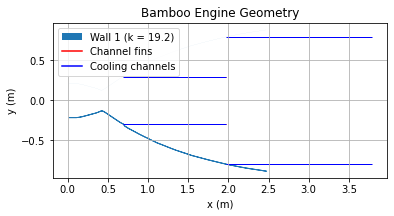

In [7]:
# Run simulation
bamboo_results = engine.steady_heating_analysis(counterflow = False, num_grid = 2000)
engine.plot()
plt.title("Bamboo Engine Geometry")
plt.show()

In [8]:
print(bamboo_results["info"]["T"])

Temperature at each position (K). T[i][j], is the temperature at x[i], at the j'th wall boundary. j = 0 corresponds to the coolant, j = -1 corresponds to the exhaust gas.


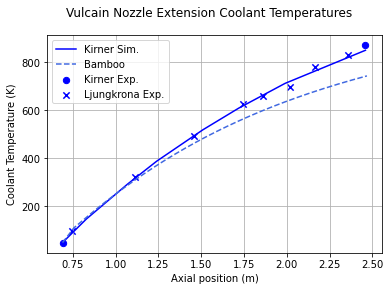

Experimental coolant exit temperature (Kirner) = 871.91 K
Predicted coolant exit temperature (Bamboo) = 744.11 K
Percentage error in coolant exit temperature = 14.66%



In [9]:
# Plot coolant temperatures
fig, ax = plt.subplots()
fig.suptitle("Vulcain Nozzle Extension Coolant Temperatures")

# Plot coolant temperatures      
ax.plot(data["Kirner"]["Extension Coolant Temperature (Sim)"]["x"], 
        data["Kirner"]["Extension Coolant Temperature (Sim)"]["y"], 
        label = "Kirner Sim.", 
        color= "blue")

ax.plot(bamboo_results["x"], 
        bamboo_results["T_coolant"], 
        label= "Bamboo", 
        color= "royalblue", 
        linestyle = "--")

# Plot their experimental datapoints
ax.scatter(data["Kirner"]["Extension Coolant Temperature (Exp)"]["x"],
           data["Kirner"]["Extension Coolant Temperature (Exp)"]["y"], 
           s = 40, 
           marker = 'o', 
           color = "blue",
           label = "Kirner Exp.")

ax.scatter(data["Ljungkrona"]["Extension Coolant Temperature (Exp)"]["x"], 
           data["Ljungkrona"]["Extension Coolant Temperature (Exp)"]["y"], 
           s = 40, 
           marker = 'x', 
           color = "blue",
           label = "Ljungkrona Exp.")

# Formatting
ax.set_ylabel("Coolant Temperature (K)")
ax.set_xlabel("Axial position (m)")
ax.grid()
ax.legend()
plt.show()

print(f'Experimental coolant exit temperature (Kirner) = {data["Kirner"]["Extension Coolant Temperature (Exp)"]["y"][-1]:.2f} K')
print(f'Predicted coolant exit temperature (Bamboo) = {bamboo_results["T_coolant"][-1]:.2f} K')
percent_error = 100*(bamboo_results["T_coolant"][-1] - data["Kirner"]["Extension Coolant Temperature (Exp)"]["y"][-1])/data["Kirner"]["Extension Coolant Temperature (Exp)"]["y"][-1]
print(f'Percentage error in coolant exit temperature = {abs(percent_error):.2f}%\n')